# Normalizing full-length gene sequencing data from the Cell Census

The Cell Census is a versioned container for the single-cell data hosted at [CELLxGENE Discover](https://cellxgene.cziscience.com/). The Cell Census utilizes [SOMA](https://github.com/single-cell-data/SOMA/blob/main/abstract_specification.md) powered by [TileDB](https://tiledb.com/products/tiledb-embedded) for storing, accessing, and efficiently filtering data.

This notebook shows you how to fetch full-length gene sequencing data from the Cell Census and normalize it to account for gene lenght.


## Contents

- Opening the census
- Fetching example full-length sequencing data (Smart-Seq2)
- Normalizing expression to account for gene length
- Validation through clustering analysis

## Opening the census

First we open the Cell Census, if you are not familiar with the basics of the Cell Census API you should take a look at the notebook "Learning about the CELLxGENE Cell Census" in `comp_bio_census_info.ipynb`.

In [1]:
import cell_census
import scanpy as sc
import numpy as np
from scipy.sparse import csr_matrix

census = cell_census.open_soma()

You can learn more about the all of the `cell_census` methods by accessing their corresponding documention via `help()`. For example `help(cell_census.open_soma)`. 

## Fetching full-length example sequencing data (Smart-Seq)

Let's get some example data, in this case we'll fetch all cells from a relatively small dataset derived from the Smart-Seq2 technology which performs full-length gene sequencing:

- Collection: [Tabula Muris Senis](https://cellxgene.cziscience.com/collections/0b9d8a04-bb9d-44da-aa27-705bb65b54eb)
- Dataset: [Liver - A single-cell transcriptomic atlas characterizes ageing tissues in the mouse - Smart-seq2](https://cellxgene.cziscience.com/e/524179b0-b406-4723-9c46-293ffa77ca81.cxg/)

Let's first find this dataset's id by using the dataset table of the cell census

In [2]:
liver_dataset = census["census_info"]["datasets"].read(
    value_filter="dataset_title == 'Liver - A single-cell transcriptomic atlas characterizes ageing tissues in the mouse - Smart-seq2'"
).concat().to_pandas()
liver_dataset

,soma_joinid,collection_id,collection_name,collection_doi,dataset_id,dataset_title,dataset_h5ad_path,dataset_total_cell_count
0,145,0b9d8a04-bb9d-44da-aa27-705bb65b54eb,Tabula Muris Senis,10.1038/s41586-020-2496-1,4546e757-34d0-4d17-be06-538318925fcd,Liver - A single-cell transcriptomic atlas cha...,4546e757-34d0-4d17-be06-538318925fcd.h5ad,2859


Now we can use this id to fetch the data.

In [3]:
liver_dataset_id = "4546e757-34d0-4d17-be06-538318925fcd"
liver_adata = cell_census.get_anndata(census, organism="Mus musculus", obs_value_filter=f"dataset_id=='{liver_dataset_id}'")

Let's make sure this data only contains Smart-Seq2 cells

In [4]:
liver_adata.obs["assay"].value_counts()

Smart-seq2    2859
Name: assay, dtype: int64

Great! As you can see this a small dataset only containing **2,859** cells. Now let's proceed to normalize by gene lengths.

For good practice let's add the number of genes expressed by cell, and the total counts per cell.

## Normalizing expression to account for gene length

By default `cell_census.get_anndata()` fetches all genes in the Cell Census. So let's first identify the genes that were measured in this dataset and subset the `AnnData` to only include those. 

To this goal we can use the "Dataset Presence Matrix" in `census["census_data"]["mus_musculus"].ms["RNA"]["feature_dataset_presence_matrix"]`. This is a boolean matrix `N x M` where `N` is the number of datasets and `M` is the number of genes in the Cell Census, `True` indicates that a gene was measured in a dataset.

In [5]:
liver_adata.n_vars

52392

Let's get the genes measured in this dataset.

In [6]:
presence_matrix = cell_census.get_presence_matrix(census, "Mus musculus", "RNA")
presence_matrix = presence_matrix[136, :]
gene_presence = presence_matrix.nonzero()[1]

liver_adata = liver_adata[:, gene_presence].copy()

In [7]:
liver_adata.n_vars

19664

We can see that out of the all genes in the Cell Census **17,992** were measured in this dataset. 

Now let's normalize these genes by gene length. We can easily do this because the Cell Census has gene lengths included in the gene metadata under `feature_length`.

In [8]:
liver_adata.X[:5, :5].toarray()

array([[2170.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.],
       [   0.,  639.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,   84.,    0.]], dtype=float32)

In [9]:
gene_lengths = liver_adata.var[["feature_length"]].to_numpy()
liver_adata.X = csr_matrix((liver_adata.X.T / gene_lengths).T)

In [10]:
liver_adata.X[:5, :5].toarray()

array([[0.60563773, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.64028056, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.0443038 , 0.        ]])

All done! You can see that we now have real numbers instead of integers.

## Validation through clustering analysis

Let's perform some basic clustering analysis to see if cell types cluster as expected using the normalized counts.

First we do some basic filtering of cells and genes.

In [11]:
sc.pp.filter_cells(liver_adata, min_genes=500)
sc.pp.filter_genes(liver_adata, min_cells=5)

Then we normalize to account for sequencing depth and transform data to log scale.

In [12]:
sc.pp.normalize_total(liver_adata, target_sum=1e4)
sc.pp.log1p(liver_adata)

Then we subset to highly variable genes.

In [13]:
sc.pp.highly_variable_genes(liver_adata, n_top_genes=1000)
liver_adata = liver_adata[:, liver_adata.var.highly_variable].copy()

And finally we scale values across the gene axis.

In [14]:
sc.pp.scale(liver_adata, max_value=10)

Now we can proceed to do clustering analysis

/home/ubuntu/cell-census/api/python/notebooks/venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


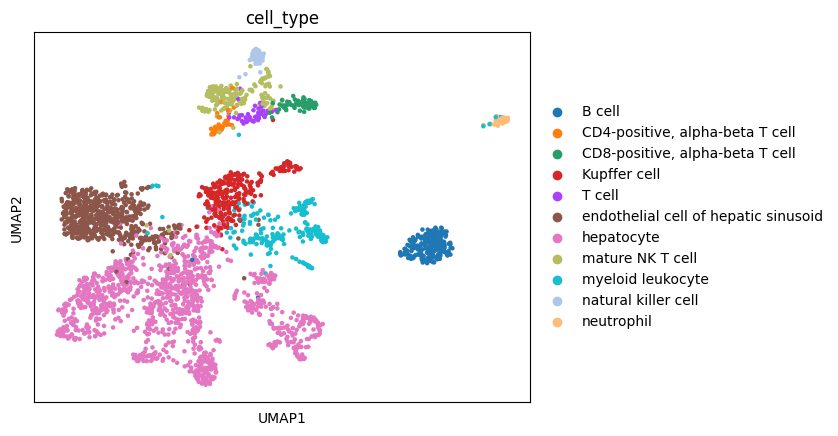

In [15]:
sc.tl.pca(liver_adata)
sc.pp.neighbors(liver_adata)
sc.tl.umap(liver_adata)
sc.pl.umap(liver_adata, color="cell_type")

With a few exceptions we can see that all cells from the same cell type cluster near each other which serves as a sanity check for the gene-length normalization that we applied.